In [39]:
import sys
import os
import pandas as pd

# Jupyter 노트북에서 현재 디렉토리 가져오기
current_dir = os.getcwd()
sys.path.append(current_dir)

In [15]:
# 한국어 컬럼명을 영어로 변환하는 매핑 딕셔너리 (실제 컬럼명에 맞게 수정)
column_mapping = {
    '일자': 'date',
    '시가': 'open',
    '고가': 'high', 
    '저가': 'low',
    '종가': 'close',
    '대비': 'change',
    '등락률': 'change_rate',
    '거래량': 'volume',
    '거래대금': 'trading_value',
    '시가총액': 'market_cap',
    '순자산가치(NAV)': 'nav',
    '순자산총액': 'total_nav',
    '상장좌수': 'shares_outstanding',
    '기초지수_지수명': 'underlying_index_name',
    '기초지수_종가': 'underlying_index_close',
    '기초지수_대비': 'underlying_index_change',
    '기초지수_등락률': 'underlying_index_change_rate'
}

# CSV 파일을 안전하게 읽기 위한 함수 (인코딩 자동 감지)
def read_csv_with_encoding(file_path):
    encodings = ['utf-8', 'euc-kr', 'cp949', 'utf-8-sig']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"성공적으로 읽음 (인코딩: {encoding})")
            return df
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"오류 발생 (인코딩: {encoding}): {e}")
            continue
    
    raise ValueError(f"파일을 읽을 수 없습니다: {file_path}")

# 데이터 폴더 내 모든 CSV 파일 처리
data_folder = 'data'
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

print(f"처리할 파일 수: {len(csv_files)}")

for file in csv_files:
    file_path = os.path.join(data_folder, file)
    print(f"\n처리 중: {file}")
    
    try:
        # CSV 파일 읽기 (인코딩 자동 감지)
        df = read_csv_with_encoding(file_path)
        
        # 원본 컬럼명 출력
        print(f"원본 컬럼: {df.columns.tolist()}")
        
        # 컬럼명 변경 (매핑에 있는 컬럼만)
        df.rename(columns=column_mapping, inplace=True)
        
        # 변경된 컬럼명 출력
        print(f"변경된 컬럼: {df.columns.tolist()}")
        
        # 변경된 파일 저장 (UTF-8로 저장)
        df.to_csv(file_path, index=False, encoding='utf-8')
        print(f"저장 완료: {file}")
        
    except Exception as e:
        print(f"파일 처리 실패 ({file}): {e}")
        continue

print("\n모든 파일 처리 완료!")


처리할 파일 수: 17

처리 중: 200030.csv
성공적으로 읽음 (인코딩: utf-8)
원본 컬럼: ['일자', 'close', '대비', '등락률', '순자산가치(NAV)', 'open', 'high', 'low', 'volume', 'trading_value', 'market_cap', '순자산총액', '상장좌수', '기초지수_지수명', '기초지수_종가', '기초지수_대비', '기초지수_등락률']
변경된 컬럼: ['date', 'close', 'change', 'change_rate', 'nav', 'open', 'high', 'low', 'volume', 'trading_value', 'market_cap', 'total_nav', 'shares_outstanding', 'underlying_index_name', 'underlying_index_close', 'underlying_index_change', 'underlying_index_change_rate']
저장 완료: 200030.csv

처리 중: 453640.csv
성공적으로 읽음 (인코딩: euc-kr)
원본 컬럼: ['일자', '종가', '대비', '등락률', '순자산가치(NAV)', '시가', '고가', '저가', '거래량', '거래대금', '시가총액', '순자산총액', '상장좌수', '기초지수_지수명', '기초지수_종가', '기초지수_대비', '기초지수_등락률']
변경된 컬럼: ['date', 'close', 'change', 'change_rate', 'nav', 'open', 'high', 'low', 'volume', 'trading_value', 'market_cap', 'total_nav', 'shares_outstanding', 'underlying_index_name', 'underlying_index_close', 'underlying_index_change', 'underlying_index_change_rate']
저장 완료: 453640.csv

처리 중: 2

In [57]:
# 모든 파일의 종가 데이터를 하나의 DataFrame으로 병합 (수정된 버전)
import datetime

# 날짜 형식을 통일하는 함수
def standardize_date(date_str):
    """날짜 형식을 YYYY-MM-DD로 통일"""
    if pd.isna(date_str):
        return date_str
    
    date_str = str(date_str)
    # 2025/08/06 형식을 2025-08-06으로 변환
    if '/' in date_str:
        return date_str.replace('/', '-')
    return date_str

# 콤마가 포함된 숫자를 float로 변환하는 함수
def clean_price(price_str):
    """콤마가 포함된 가격 문자열을 숫자로 변환"""
    if pd.isna(price_str):
        return price_str
    
    price_str = str(price_str)
    # 콤마 제거 후 숫자로 변환
    try:
        return float(price_str.replace(',', ''))
    except:
        return price_str

# 첫 번째 파일로 기본 DataFrame 초기화
csv_files = [f for f in os.listdir('data') if f.endswith('.csv')]
print(f"처리할 파일 수: {len(csv_files)}")

close_df = pd.DataFrame()

for i, file in enumerate(csv_files):
    print(f"처리 중 ({i+1}/{len(csv_files)}): {file}")
    
    # 파일 읽기 (인코딩 자동 감지)
    df = read_csv_with_encoding(f'data/{file}')
    
    # 필요한 컬럼만 선택
    if 'date' in df.columns and 'volume' in df.columns:
        df_temp = df[['date', 'volume']].copy()
        
        # 날짜 형식 통일
        df_temp['date'] = df_temp['date'].apply(standardize_date)
        
        # 종가 데이터 정리 (콤마 제거)
        df_temp['volume'] = df_temp['volume'].apply(clean_price)
        
        # 컬럼명을 파일명_close로 변경
        ticker = file.split('.')[0]
        df_temp = df_temp.rename(columns={'volume': f'{ticker}_volume'})
        
        # 날짜를 인덱스로 설정
        df_temp = df_temp.set_index('date')
        
        # DataFrame 병합
        if close_df.empty:
            close_df = df_temp
        else:
            close_df = close_df.join(df_temp, how='outer')
            
        print(f"  - 추가된 컬럼: {ticker}_close")
    else:
        print(f"  - 경고: 필요한 컬럼이 없습니다 (date, close)")

print(f"\n병합 완료!")
print(f"전체 형태: {close_df.shape}")
print(f"컬럼명: {list(close_df.columns)}")
print(f"\n처음 5행:")
print(close_df.head())


처리할 파일 수: 21
처리 중 (1/21): 200030.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 200030_close
처리 중 (2/21): realized_volatility_3d.csv
성공적으로 읽음 (인코딩: utf-8)
  - 경고: 필요한 컬럼이 없습니다 (date, close)
처리 중 (3/21): 453640.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 453640_close
처리 중 (4/21): 261070.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 261070_close
처리 중 (5/21): realized_volatility_15d.csv
성공적으로 읽음 (인코딩: utf-8)
  - 경고: 필요한 컬럼이 없습니다 (date, close)
처리 중 (6/21): 244580.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 244580_close
처리 중 (7/21): 248270.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 248270_close
처리 중 (8/21): 143860.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 143860_close
처리 중 (9/21): realized_volatility_1m.csv
성공적으로 읽음 (인코딩: utf-8)
  - 경고: 필요한 컬럼이 없습니다 (date, close)
처리 중 (10/21): 440910.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 440910_close
처리 중 (11/21): 253280.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 253280_close
처리 중 (12/21): 227550.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가된 컬럼: 227550_close
처리 중 (13/21): 203780.csv
성공적으로 읽음 (인코딩: utf-8)
  - 추가

In [58]:
# 데이터 품질 확인 및 후처리
print("=== 데이터 품질 분석 ===")
print(f"전체 행 수: {len(close_df)}")
print(f"전체 컬럼 수: {len(close_df.columns)}")
print(f"날짜 범위: {close_df.index.min()} ~ {close_df.index.max()}")

print("\n=== 각 종목별 데이터 개수 ===")
for col in close_df.columns:
    non_null_count = close_df[col].count()
    print(f"{col}: {non_null_count}개")

print("\n=== 결측값 비율 ===")
missing_ratio = (close_df.isnull().sum() / len(close_df) * 100).round(2)
print(missing_ratio)

# 날짜 순서로 정렬 (최신 날짜가 위로)
close_df_sorted = close_df.sort_index(ascending=False)

print("\n=== 최신 데이터 (최근 10일) ===")
print(close_df_sorted.head(10))


=== 데이터 품질 분석 ===
전체 행 수: 4246
전체 컬럼 수: 17
날짜 범위: 2008-05-29 ~ 2025-08-07

=== 각 종목별 데이터 개수 ===
200030_volume: 2740개
453640_volume: 582개
261070_volume: 2120개
244580_volume: 2268개
248270_volume: 2234개
143860_volume: 3459개
440910_volume: 720개
253280_volume: 2178개
227550_volume: 2422개
203780_volume: 2687개
140710_volume: 3515개
185680_volume: 2890개
463050_volume: 480개
227540_volume: 2422개
266420_volume: 2051개
460280_volume: 516개
102960_volume: 4245개

=== 결측값 비율 ===
200030_volume    35.47
453640_volume    86.29
261070_volume    50.07
244580_volume    46.59
248270_volume    47.39
143860_volume    18.54
440910_volume    83.04
253280_volume    48.70
227550_volume    42.96
203780_volume    36.72
140710_volume    17.22
185680_volume    31.94
463050_volume    88.70
227540_volume    42.96
266420_volume    51.70
460280_volume    87.85
102960_volume     0.02
dtype: float64

=== 최신 데이터 (최근 10일) ===
            200030_volume  453640_volume  261070_volume  244580_volume  \
date                          

In [60]:
close_df_sorted.to_csv('data/ETF_volume.csv', encoding='utf-8')

In [48]:
RV_3d = pd.read_csv('data/realized_volatility_3d.csv', index_col=0).sort_index(ascending=True).fillna(0)
RV_15d = pd.read_csv('data/realized_volatility_15d.csv', index_col=0).sort_index(ascending=True).fillna(0)
RV_1m = pd.read_csv('data/realized_volatility_1m.csv', index_col=0).sort_index(ascending=True).fillna(0)

In [67]:
RV_3d.columns = [col.replace(
    '_RV_3d', '') for col in RV_3d.columns]
RV_15d.columns = [col.replace(
    '_RV_15d', '') for col in RV_15d.columns]
RV_1m.columns = [col.replace(
    '_RV_1m', '') for col in RV_1m.columns]

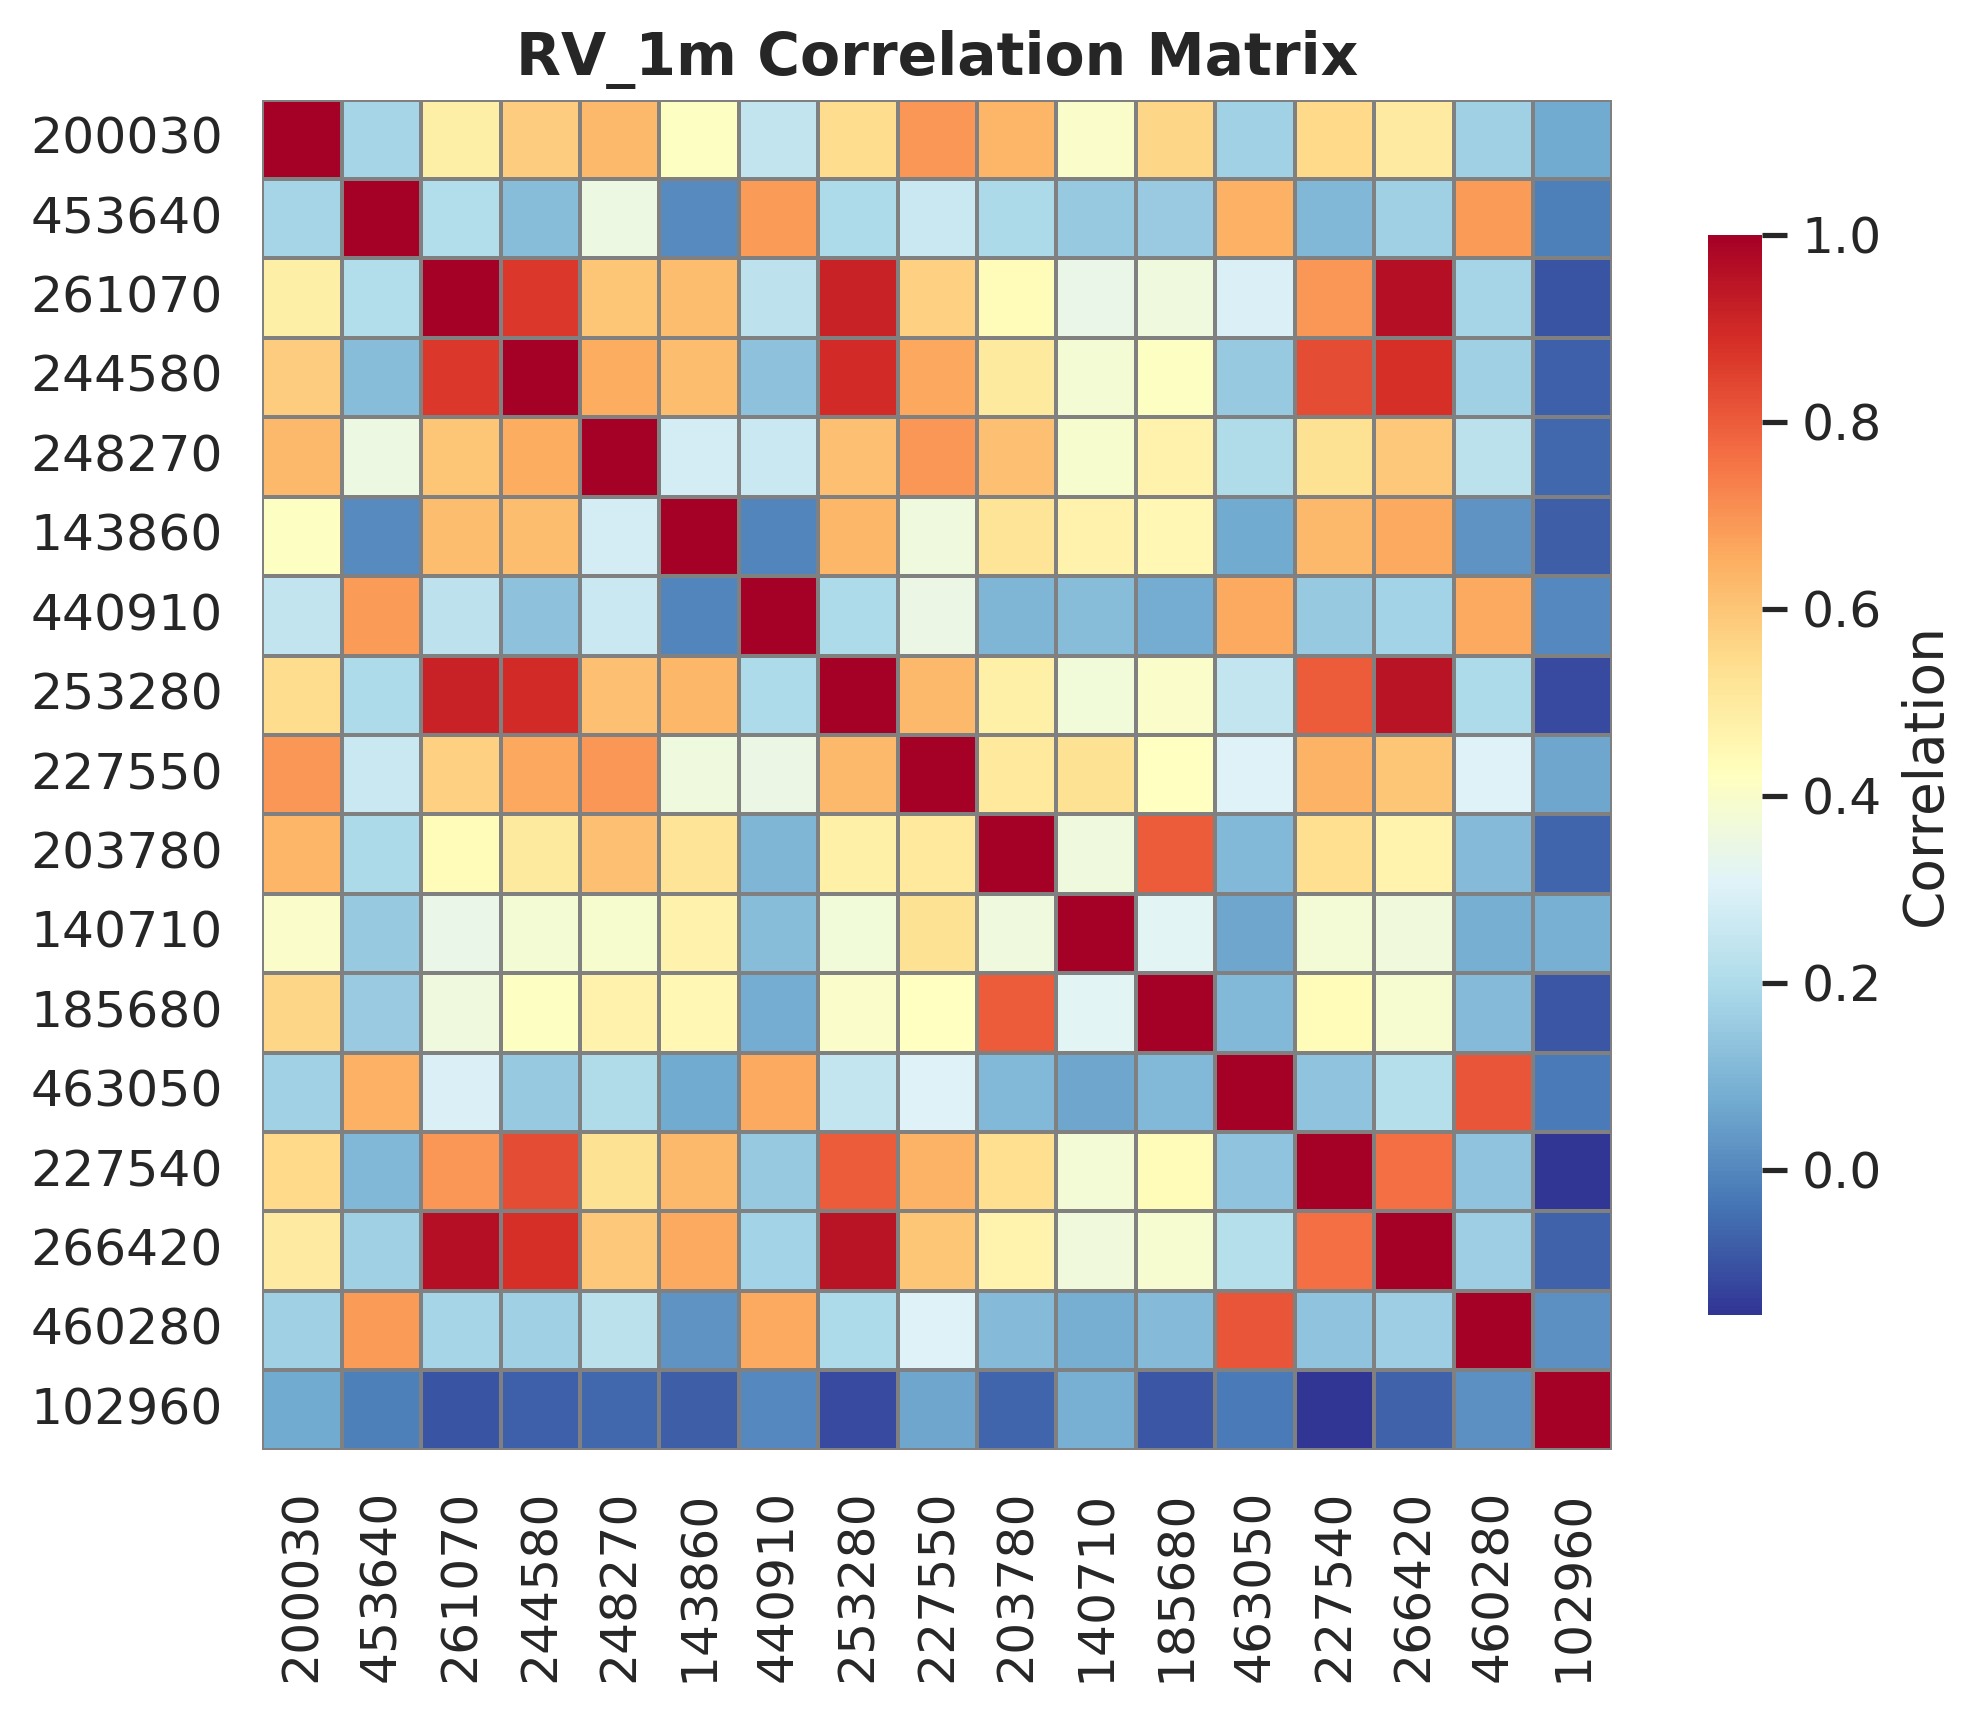

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 스타일 세팅
sns.set_theme(style="white", font_scale=1.1)

# 캔버스 크기
plt.figure(figsize=(8, 6), dpi=300)

# 상관계수 계산
corr = RV_1m.corr()

# mask 사용 안 하고 전체 보여주기
sns.heatmap(
    corr,
    cmap="RdYlBu_r",
    annot=False,  # 숫자 제거
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    linewidths=0.5,
    linecolor="gray",
    square=True
)

plt.title("RV_1m Correlation Matrix", fontsize=14, weight="bold")
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)  # 여백 조절
plt.show()


In [71]:
RV_3d = pd.read_csv('data/volume_3d.csv', index_col=0).sort_index(ascending=True).fillna(0)
RV_15d = pd.read_csv('data/volume_15d.csv', index_col=0).sort_index(ascending=True).fillna(0)
RV_1m = pd.read_csv('data/volume_1m.csv', index_col=0).sort_index(ascending=True).fillna(0)

In [73]:
RV_3d.columns = [col.replace(
    '_volume_3d', '') for col in RV_3d.columns]
RV_15d.columns = [col.replace(
    '_volume_15d', '') for col in RV_15d.columns]
RV_1m.columns = [col.replace(
    '_volume_1m', '') for col in RV_1m.columns]

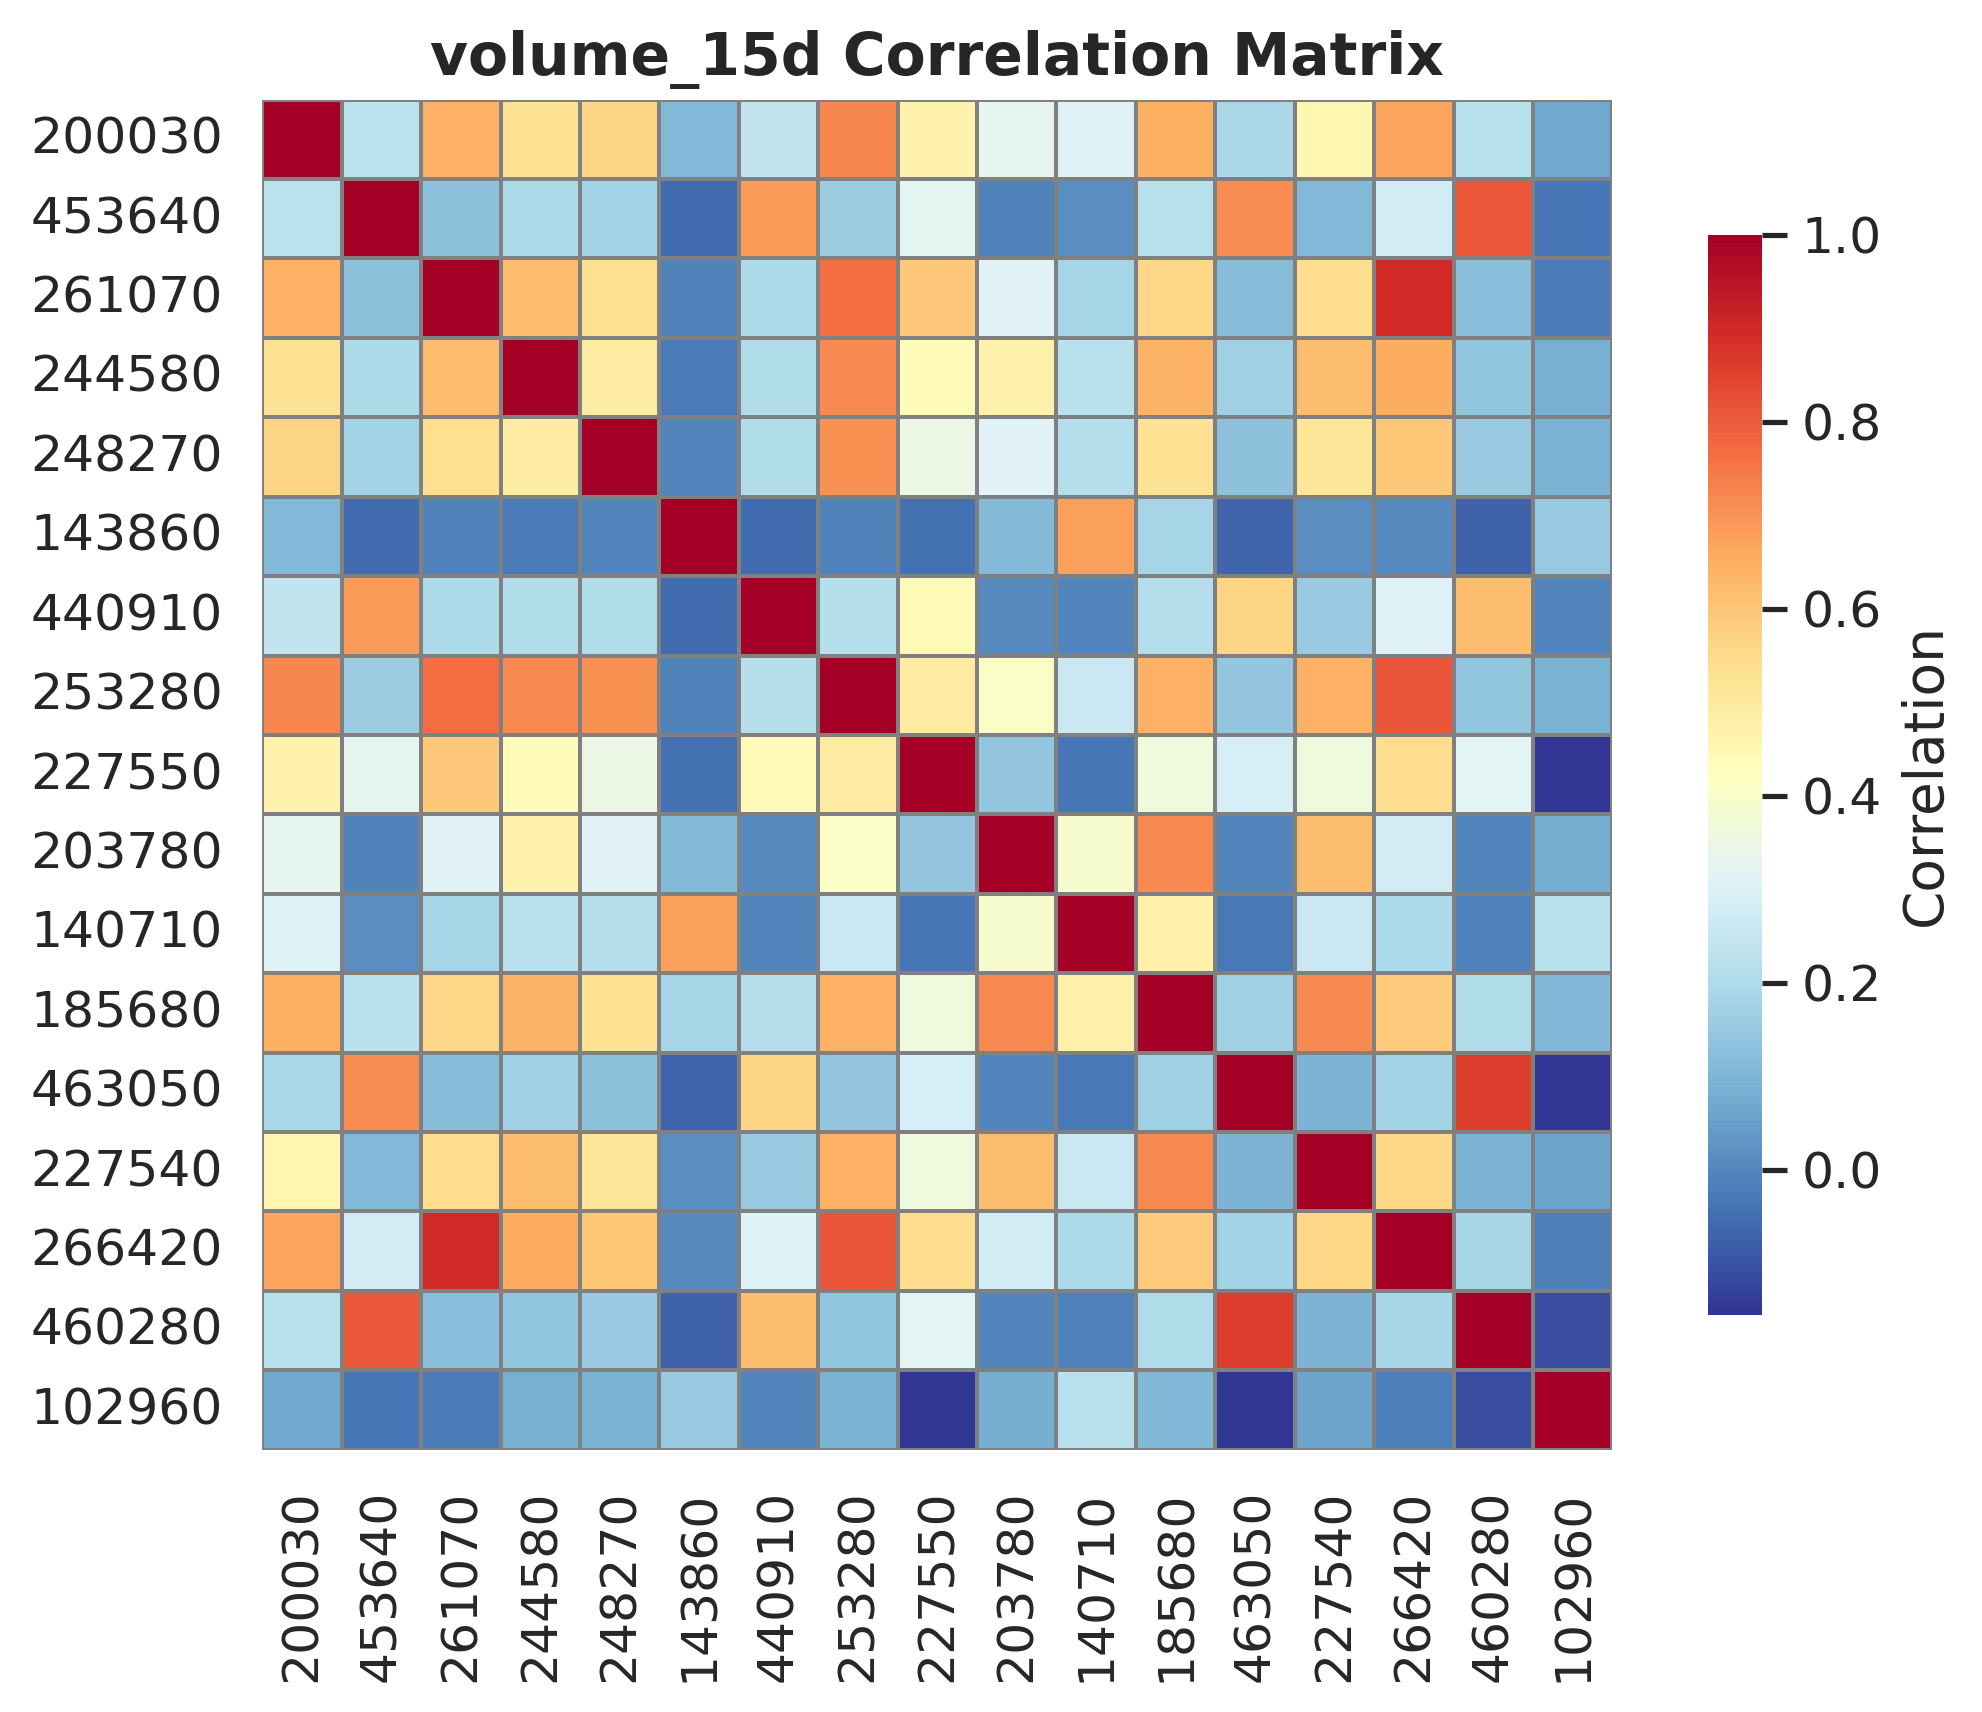

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 스타일 세팅
sns.set_theme(style="white", font_scale=1.1)

# 캔버스 크기
plt.figure(figsize=(8, 6), dpi=300)

# 상관계수 계산
corr = RV_15d.corr()

# mask 사용 안 하고 전체 보여주기
sns.heatmap(
    corr,
    cmap="RdYlBu_r",
    annot=False,  # 숫자 제거
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    linewidths=0.5,
    linecolor="gray",
    square=True
)

plt.title("volume_15d Correlation Matrix", fontsize=14, weight="bold")
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)  # 여백 조절
plt.show()


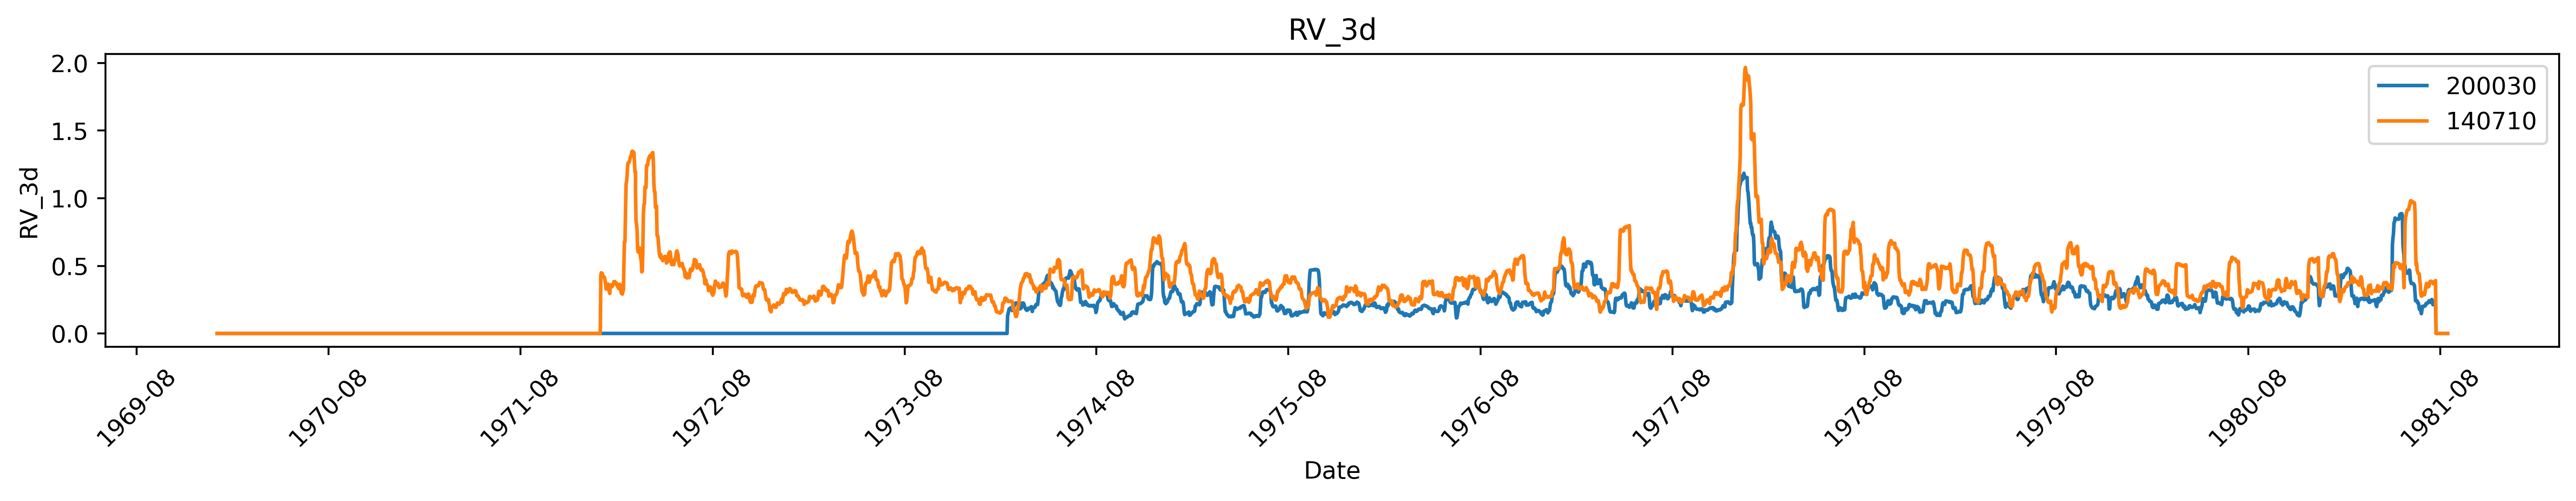

In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


plt.figure(figsize=(15, 3), dpi=400)
plt.plot(RV_3d.index, RV_3d['200030_RV_3d'])
plt.plot(RV_3d.index, RV_3d['140710_RV_3d'])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # 1개월 간격
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('RV_3d')
plt.title('RV_3d')
plt.legend(['200030', '140710'])
plt.tight_layout()
plt.show()